In [53]:
import random
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
import time

from pprint import pprint
from PIL import Image, ImageDraw, ImageFont
from math import ceil, floor

In [118]:
def returnJSON(grid_formatted, rows,cols):
    grid = []
    grid_nums = []
    across_clue_num = []
    down_clue_num = []
    # if (x,y) is present in these array the cell (x,y) is already accounted as a part of answer of across or down
    in_horizontal = []
    in_vertical = []


    num = 0

    for x in range(0, cols ):
        for y in range(0, rows):

            # if the cell is black there's no need to number
            if grid_formatted[x][y] == '.':
                grid_nums.append(0)
                continue

            # if the cell is part of both horizontal and vertical cell then there's no need to number
            horizontal_presence = (x, y) in in_horizontal
            vertical_presence = (x, y) in in_vertical

            # present in both 1 1
            if horizontal_presence and vertical_presence:
                grid_nums.append(0)
                continue

            # present in one i.e 1 0
            if not horizontal_presence and vertical_presence:
                horizontal_length = 0
                temp_horizontal_arr = []
                # iterate in x direction until the end of the grid or until a black box is found
                while x + horizontal_length < rows and grid_formatted[x + horizontal_length][y] != '.':
                    temp_horizontal_arr.append((x + horizontal_length, y))
                    horizontal_length += 1
                # if horizontal length is greater than 1, then append the temp_horizontal_arr to in_horizontal array
                if horizontal_length > 1:
                    in_horizontal.extend(temp_horizontal_arr)
                    num += 1
                    across_clue_num.append(num)
                    grid_nums.append(num)
                    continue
                grid_nums.append(0)
            # present in one 1 0
            if not vertical_presence and horizontal_presence:
                # do the same for vertical
                vertical_length = 0
                temp_vertical_arr = []
                # iterate in y direction until the end of the grid or until a black box is found
                while y + vertical_length < cols  and grid_formatted[x][y+vertical_length] != '.':
                    temp_vertical_arr.append((x, y+vertical_length))
                    vertical_length += 1
                # if vertical length is greater than 1, then append the temp_vertical_arr to in_vertical array
                if vertical_length > 1:
                    in_vertical.extend(temp_vertical_arr)
                    num += 1
                    down_clue_num.append(num)
                    grid_nums.append(num)
                    continue
                grid_nums.append(0)

            if(not horizontal_presence and not vertical_presence):

                horizontal_length = 0
                temp_horizontal_arr = []
                # iterate in x direction until the end of the grid or until a black box is found
                while x + horizontal_length < rows  and grid_formatted[x + horizontal_length][y] != '.':
                    temp_horizontal_arr.append((x + horizontal_length, y))
                    horizontal_length += 1
                # if horizontal length is greater than 1, then append the temp_horizontal_arr to in_horizontal array

                # do the same for vertical
                vertical_length = 0
                temp_vertical_arr = []
                # iterate in y direction until the end of the grid or until a black box is found
                while y + vertical_length < cols  and grid_formatted[x][y+vertical_length] != '.':
                    temp_vertical_arr.append((x, y+vertical_length))
                    vertical_length += 1
                # if vertical length is greater than 1, then append the temp_vertical_arr to in_vertical array

                if horizontal_length > 1 and horizontal_length > 1:
                    in_horizontal.extend(temp_horizontal_arr)
                    in_vertical.extend(temp_vertical_arr)
                    num += 1
                    across_clue_num.append(num)
                    down_clue_num.append(num)
                    grid_nums.append(num)
                elif vertical_length > 1:
                    in_vertical.extend(temp_vertical_arr)
                    num += 1
                    down_clue_num.append(num)
                    grid_nums.append(num)
                elif horizontal_length > 1:
                    in_horizontal.extend(temp_horizontal_arr)
                    num += 1
                    across_clue_num.append(num)
                    grid_nums.append(num)
                else:
                    grid_nums.append(0)


    size = { 'rows' : rows,
            'cols' : cols,
            }

    dict = {
        'size' : size,
        'grid' : sum(grid_formatted, []),
        'gridnums': grid_nums,
        'across_nums': down_clue_num,
        'down_nums' : across_clue_num,
        'clues':{
            'across':[],
            'down':[]
        }
    }

    return dict

In [165]:
def check_status(grid):
    """
    Check the status of the crossword grid by verifying if every white square
    participates in a valid horizontal and vertical series of at least min_count.

    Parameters:
    - grid (list): The crossword grid.

    Returns:
    - bool: True if the grid is valid, False otherwise.
    """
    for row in range(len(grid)):
        for column in range(len(grid[row])):
            if grid[row][column] == ' ':
                # Check horizontally
                c1 = check_series(grid, row, column, 0, -1) + check_series(grid, row, column, 0, 1) -1

                # Check horizontally to the right
                # c1 |= check_series(grid, row, column, 0, 1)

                # Check vertically upwards
                c2 = check_series(grid, row, column, -1, 0) + check_series(grid, row, column, 1, 0) -1

                # Check vertically
                # c2 |= check_series(grid, row, column, 1, 0)
                if not (c1>=3 and c2>=3):
                    return False
    return True

def check_series(grid, start_row, start_column, row_increment, column_increment, min_count = 3):
    """
    Check if a valid series of at least min_count exists in a specific direction
    starting from the given position.

    Parameters:
    - grid (list): The crossword grid.
    - start_row (int): Starting row index.
    - start_column (int): Starting column index.
    - row_increment (int): Row direction (1, 0, or -1).
    - column_increment (int): Column direction (1, 0, or -1).
    - min_count (int): Minimum count required for a valid series.

    Returns:
    - count: number of white tiles in a specific direction
    """
    count = 1
    current_row, current_column = start_row + row_increment, start_column + column_increment
    while 0 <= current_row < len(grid) and 0 <= current_column < len(grid[start_row]):
        if grid[current_row][current_column] == ' ':
            count += 1
            current_row += row_increment
            current_column += column_increment
        else:
            break

    return count

def create_crossword_grid(rows, cols):
    """
    Create an empty crossword grid with the specified number of rows and columns.

    Parameters:
    - rows (int): Number of rows.
    - cols (int): Number of columns.

    Returns:
    - list: Empty crossword grid.
    """
    grid = [[' ' for _ in range(cols)] for _ in range(rows)]
    return grid

def add_black_squares(grid, max_iters = 600):
    """
    Add black squares to the crossword grid based on probability calculations.

    Parameters:
    - grid (list): The crossword grid.
    - black_tiles (list): List of indices representing black squares.

    Returns:
    - None
    """
    black_tiles = []
    white_tiles = [x for x in range(len(grid) * len(grid[0])) if x not in black_tiles]
    needed_black = floor(len(grid) * len(grid[0]) / 6)
    max_iterations = max_iters  # Set a reasonable maximum iteration count

    iterations = 0

    while iterations < max_iterations:
        if len(black_tiles) >= needed_black:
            break
        # Check for empty columns and rows
        empty_columns = [col for col in range(len(grid[0])) if all(row[col] == ' ' for row in grid)]
        empty_rows = [row for row in range(len(grid)) if all(cell == ' ' for cell in grid[row])]

        # print(empty_columns, empty_rows)

        # Ensure that empty rows and columns cannot exist for grids larger than size 7
        if len(grid) > 7:
            empty_columns = [] if len(empty_columns) == len(grid[0]) else empty_columns
            empty_rows = [] if len(empty_rows) == len(grid) else empty_rows

        if empty_columns and random.random() < 0.5:
            col = random.choice(empty_columns)
            row = random.randint(0, len(grid) - 1)
        elif empty_rows:
            row = random.choice(empty_rows)
            col = random.randint(0, len(grid[0]) - 1)
        else:
            row, col = divmod(random.choice(white_tiles), len(grid[0]))

        odds_row = (needed_black - len(black_tiles)) / len(grid) ** 1.5
        odds_col = (needed_black - len(black_tiles)) / len(grid[0]) ** 1.5

        # Adjust the probability for corners and other cells based on the crossword size
        if len(grid) > 7:
            if (row, col) in [(0, 0), (0, len(grid[0]) - 1), (len(grid) - 1, 0), (len(grid) - 1, len(grid[0]) - 1)]:
                odds_corner = 0.1  # Decrease the probability for corners
            else:
                odds_corner = 1.5  # Increase the probability for other cells
        else:
            odds_corner = 1.0  # Default odds for smaller crosswords

        if grid[row][col] == ' ' and random.random() < max(odds_row, odds_col, odds_corner):
            grid[row][col] = '.'
            sym_row = len(grid) - 1 - row
            sym_col = len(grid[0]) - 1 - col
            grid[sym_row][sym_col] = '.'

            if not check_status(grid):
                grid[row][col] = ' '
                grid[sym_row][sym_col] = ' '
            else:
                black_tiles.extend([row * len(grid[0]) + col, sym_row * len(grid[0]) + sym_col])
                white_tiles.remove(row * len(grid[0]) + col)

        iterations += 1
    # if iterations == max_iterations:
    #   empty_columns = [col for col in range(len(grid[0])) if all(row[col] == ' ' for row in grid)]
    #   empty_rows = [row for row in range(len(grid)) if all(cell == ' ' for cell in grid[row])]

    #   print(empty_columns, empty_rows)


    # print(f"Needed black titles: {len(black_tiles)}\nTotal Iterations: {iterations}")
    return grid, iterations

def create_crossword_image(grid, grid_nums, cell_size = 30, black_square_color="black", text_color="black", image_file="crossword.png"):
    """
    Create an image representation of the crossword grid.

    Parameters:
    - grid (list): The crossword grid.
    - cell_size (int): Size of each cell in pixels.
    - black_square_color (str): Color for black squares.
    - text_color (str): Color for text.
    - image_file (str): File name to save the image.

    Returns:
    - None
    """
    height = len(grid) * cell_size + 1
    width = len(grid[0]) * cell_size + 1

    img = Image.new("RGB", (width, height), "white")
    draw = ImageDraw.Draw(img)

    font = ImageFont.load_default()

    # Adjust font size
    font_size = 8  # Set your desired font size
    font = ImageFont.truetype("/content/Roboto-Regular.ttf", font_size)


    for row in range(len(grid)):
        for col in range(len(grid[row])):
            x = col * cell_size
            y = row * cell_size
            rect = [(x, y), (x + cell_size, y + cell_size)]

            if grid[row][col] == ".":
                draw.rectangle(rect, fill = black_square_color)
            else:
                draw.rectangle(rect, outline = "black")
                if grid_nums[row][col] != 0:
                  draw.text((x + cell_size // 2 - 7, y + cell_size // 2 - 8), str(grid_nums[row][col]), fill=text_color, anchor="mm", font=font)

    img_array = np.array(img)
    plt.figure(figsize = (6, 6))
    plt.imshow(img_array)
    plt.axis('off')
    plt.show()
    img.save(image_file)

def generate_grid(grid_size = 15, max_iters = 600, display_grid = False):
    rows = cols = grid_size

    no_ran_iters = max_iters

    if grid_size != 4:
      while no_ran_iters == max_iters:
        crossword_grid = create_crossword_grid(rows, cols)
        crossword_grid, no_ran_iters = add_black_squares(crossword_grid, max_iters)
    else:
      crossword_grid = create_crossword_grid(rows, cols)
      crossword_grid, no_ran_iters = add_black_squares(crossword_grid, max_iters)

    # pprint(crossword_grid)

    # json data
    json_data = returnJSON(crossword_grid, rows, cols)
    grid_nums = json_data['gridnums']
    reshaped_grid = [grid_nums[i:i + rows] for i in range(0, len(grid_nums), rows)]

    # print(len(json_data['across_nums'] + json_data['down_nums']))
    # with open("crossword_json.json", 'w') as f:
    #   json.dump(json_data, f)
    if display_grid:
      create_crossword_image(crossword_grid, reshaped_grid, image_file = "crossword.png")

    return json_data

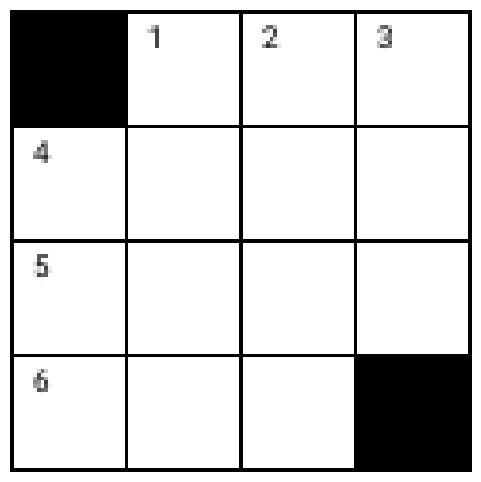

In [169]:
json_data = generate_grid(grid_size = 4, display_grid = True)

In [170]:
with open("crossword_json_4x4_2.json", 'w') as f:
  json.dump(json_data, f)